In [20]:
import numpy as np
import pandas as pd
import json
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
folder_path = "../data/FINQA"
filename="train.json"
file_path = os.path.join(folder_path, filename)
with open(file_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
print(json.dumps(train_data[0], indent=2))

{
  "pre_text": [
    "interest rate to a variable interest rate based on the three-month libor plus 2.05% ( 2.05 % ) ( 2.34% ( 2.34 % ) as of october 31 , 2009 ) .",
    "if libor changes by 100 basis points , our annual interest expense would change by $ 3.8 million .",
    "foreign currency exposure as more fully described in note 2i .",
    "in the notes to consolidated financial statements contained in item 8 of this annual report on form 10-k , we regularly hedge our non-u.s .",
    "dollar-based exposures by entering into forward foreign currency exchange contracts .",
    "the terms of these contracts are for periods matching the duration of the underlying exposure and generally range from one month to twelve months .",
    "currently , our largest foreign currency exposure is the euro , primarily because our european operations have the highest proportion of our local currency denominated expenses .",
    "relative to foreign currency exposures existing at october 31 , 2009 an

In [22]:
folder_path = "../data/FINQA"
filename="test.json"
file_path = os.path.join(folder_path, filename)
with open(file_path, "r", encoding="utf-8") as f:
    test_data = json.load(f)
print(json.dumps(test_data[0], indent=2))

{
  "pre_text": [
    "entergy corporation and subsidiaries management 2019s financial discussion and analysis a result of the entergy louisiana and entergy gulf states louisiana business combination , results of operations for 2015 also include two items that occurred in october 2015 : 1 ) a deferred tax asset and resulting net increase in tax basis of approximately $ 334 million and 2 ) a regulatory liability of $ 107 million ( $ 66 million net-of-tax ) as a result of customer credits to be realized by electric customers of entergy louisiana , consistent with the terms of the stipulated settlement in the business combination proceeding .",
    "see note 2 to the financial statements for further discussion of the business combination and customer credits .",
    "results of operations for 2015 also include the sale in december 2015 of the 583 mw rhode island state energy center for a realized gain of $ 154 million ( $ 100 million net-of-tax ) on the sale and the $ 77 million ( $ 47 mi

In [23]:
folder_path = "../data/FINQA"
filename="dev.json"
file_path = os.path.join(folder_path, filename)
with open(file_path, "r", encoding="utf-8") as f:
    dev_data = json.load(f)
print(json.dumps(dev_data[0], indent=2))

{
  "pre_text": [
    "largest operators of open-loop and closed-loop retail electronic payments networks the largest operators of open-loop and closed-loop retail electronic payments networks are visa , mastercard , american express , discover , jcb and diners club .",
    "with the exception of discover , which primarily operates in the united states , all of the other network operators can be considered multi- national or global providers of payments network services .",
    "based on payments volume , total volume , number of transactions and number of cards in circulation , visa is the largest retail electronic payments network in the world .",
    "the following chart compares our network with those of our major competitors for calendar year 2007 : company payments volume volume transactions cards ( billions ) ( billions ) ( billions ) ( millions ) visa inc. ( 1 ) .",
    ".",
    ".",
    ".",
    ".",
    ".",
    ".",
    ".",
    ".",
    ".",
    ".",
    ".",
    ".",
    "

In [24]:
print(f"Tổng số mẫu huấn luyện: {len(train_data)+len(dev_data)+len(test_data)}")
print(f"Tổng số mẫu tập train: {len(train_data)}")
print(f"Tổng số mẫu tập test: {len(test_data)}")
print(f"Tổng số mẫu tập dev: {len(dev_data)}")

Tổng số mẫu huấn luyện: 8281
Tổng số mẫu tập train: 6251
Tổng số mẫu tập test: 1147
Tổng số mẫu tập dev: 883


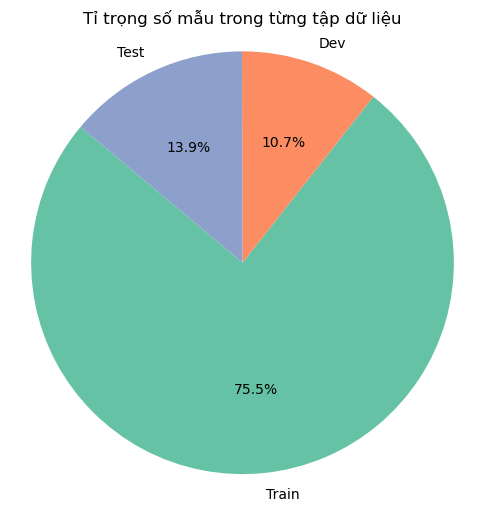

In [25]:
# Tính số lượng mẫu trong từng tập
sizes = [len(train_data), len(dev_data), len(test_data)]
labels = ['Train', 'Dev', 'Test']
colors = sns.color_palette("Set2", n_colors=len(labels))

# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Tỉ trọng số mẫu trong từng tập dữ liệu')
plt.axis('equal')  # Đảm bảo hình tròn
plt.show()


In [26]:
columns = list(train_data[0].keys())
print(columns)

['pre_text', 'post_text', 'filename', 'table_ori', 'table', 'qa', 'id', 'table_retrieved', 'text_retrieved', 'table_retrieved_all', 'text_retrieved_all']


In [27]:
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)
df_dev = pd.DataFrame(dev_data)
df = pd.concat([df_train, df_test, df_dev], ignore_index=True)

In [28]:
df["question"] = df["qa"].apply(lambda x: x.get("question") if isinstance(x, dict) else None)
df["question_token_count"] = df["question"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
print(f"Độ dài trung bình câu hỏi {df["question_token_count"].sum()/len(df)} token")
print("Độ dài tối đa câu hỏi",df["question_token_count"].max(),"token")
print("Độ dài tối thiểu câu hỏi",df["question_token_count"].min(),"token")

Độ dài trung bình câu hỏi 16.632170027774425 token
Độ dài tối đa câu hỏi 62 token
Độ dài tối thiểu câu hỏi 5 token


In [29]:
# Flatten tất cả các list trong 'pre_text' và 'post_text'
pre_text_flat = [sentence for sublist in df['pre_text'] for sentence in sublist]
post_text_flat = [sentence for sublist in df['post_text'] for sentence in sublist]

# Ghép lại thành 1 chuỗi
pre_text_all = ' '.join(pre_text_flat)
post_text_all = ' '.join(post_text_flat)

# Đếm token (tách bằng dấu cách đơn giản)
pre_tokens = pre_text_all.split()
post_tokens = post_text_all.split()
print(f"Trung bình văn bản đầu vào có {(len(pre_tokens)+len(post_tokens))/len(df)} token")


Trung bình văn bản đầu vào có 628.0819949281488 token


In [30]:
df["table_token_count"] = df["table"].apply(
    lambda x: (
        sum(
            sum(len(item.split()) for item in row if isinstance(item, str))
            for row in x if isinstance(row, list)
        ) if isinstance(x, list)  # Trường hợp x là list (bảng)
        else len(x.split()) if isinstance(x, str)  # Trường hợp x là chuỗi
        else 0  # Trường hợp khác
    )
)
print("Trung bình bảng có", df["table_token_count"].mean(),"token")
print("Bảng có tối thiểu", df["table_token_count"].min(),"token")
print("Bảng có tối đa", df["table_token_count"].max(),"token")

Trung bình bảng có 58.89832145876102 token
Bảng có tối thiểu 6 token
Bảng có tối đa 589 token


In [31]:
df["program_re"] = df["qa"].apply(lambda x: x.get("program_re") if isinstance(x, dict) else None)

def extract_operations(program_str):
    if isinstance(program_str, str):
        return re.findall(r'\b[a-zA-Z_]+\b(?=\()', program_str)
    return []

# Áp dụng hàm cho toàn bộ DataFrame
df["operations"] = df["program_re"].apply(extract_operations)

# Flatten danh sách các phép toán
all_ops = [op for ops_list in df["operations"] for op in ops_list]
# Đếm tần suất
op_counts = Counter(all_ops)
# In kết quả
for op, count in op_counts.most_common():
    print(f"{op}: {count}")

divide: 5887
subtract: 3671
add: 1956
multiply: 770
greater: 154
table_average: 129
table_max: 66
table_sum: 50
table_min: 36
exp: 9


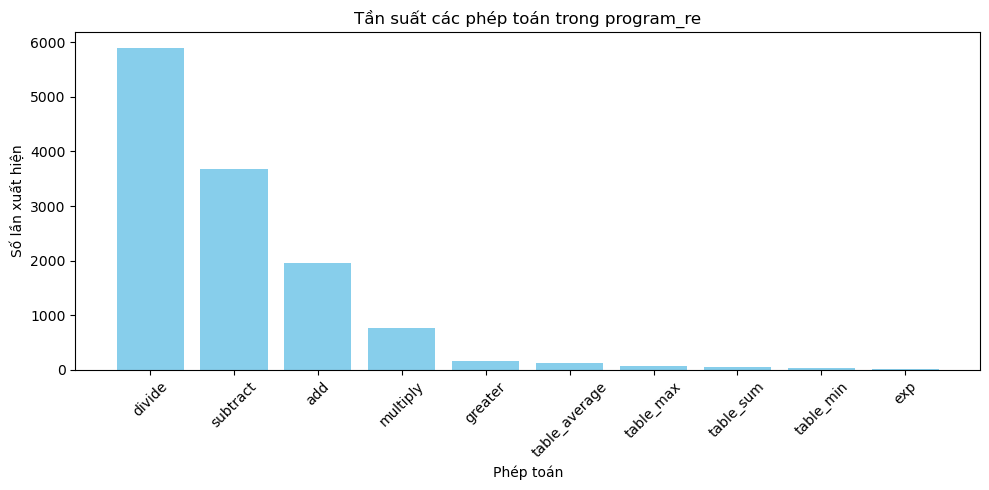

In [32]:
op_df = pd.DataFrame(op_counts.items(), columns=["Operation", "Count"]).sort_values(by="Count", ascending=False)
plt.figure(figsize=(10, 5))
plt.bar(op_df["Operation"], op_df["Count"], color='skyblue')
plt.title("Tần suất các phép toán trong program_re")
plt.xlabel("Phép toán")
plt.ylabel("Số lần xuất hiện")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
import pandas as pd
import re

def classify_answer_type(answer):
    if isinstance(answer, str):
        ans_lower = answer.strip().lower()
        if ans_lower in ["yes", "no", "true", "false"]:
            return "yes/no"
        elif re.match(r'^-?\$?\d+(\.\d+)?%?$', ans_lower):  # Dạng số, %, hoặc có $
            return "numeric"
        else:
            return "text"
    elif isinstance(answer, (int, float)):
        return "numeric"
    elif isinstance(answer, bool):
        return "yes/no"
    else:
        return "other"

# Áp dụng cho toàn bộ DataFrame
df["answer"] = df["qa"].apply(lambda x: x.get("answer") if isinstance(x, dict) else None)
df["answer_type"] = df["answer"].apply(classify_answer_type)

counts = df["answer_type"].value_counts()
print("Thống kê dạng câu trả lời:")
print(counts)


Thống kê dạng câu trả lời:
answer_type
numeric    7838
text        291
yes/no      152
Name: count, dtype: int64


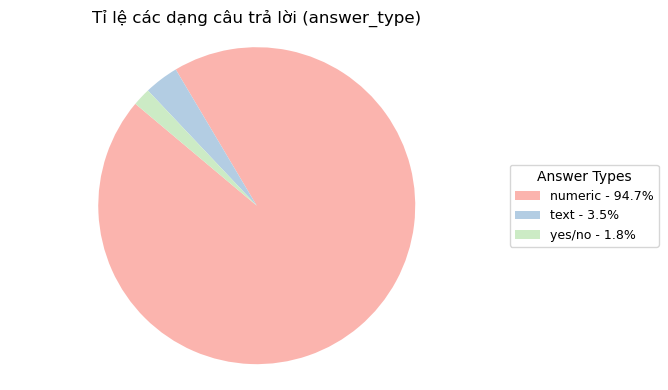

In [34]:
# Chuẩn bị dữ liệu
counts = df["answer_type"].value_counts()
labels = counts.index
sizes = counts.values

# Tạo biểu đồ tròn
fig, ax = plt.subplots(figsize=(6, 4))  # Gọn hơn
wedges, _ = ax.pie(
    sizes,
    startangle=140,
    colors=plt.cm.Pastel1.colors,  # Bảng màu nhẹ, dễ nhìn
)

# Tạo nhãn với phần trăm
percent_labels = [f"{label} - {size/sizes.sum()*100:.1f}%" for label, size in zip(labels, sizes)]

# Thêm chú thích bên phải
ax.legend(
    wedges,
    percent_labels,
    title="Answer Types",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=9
)

# Căn chỉnh và hiển thị
plt.title("Tỉ lệ các dạng câu trả lời (answer_type)")
plt.tight_layout()
plt.axis('equal')  # Giữ hình tròn
plt.show()


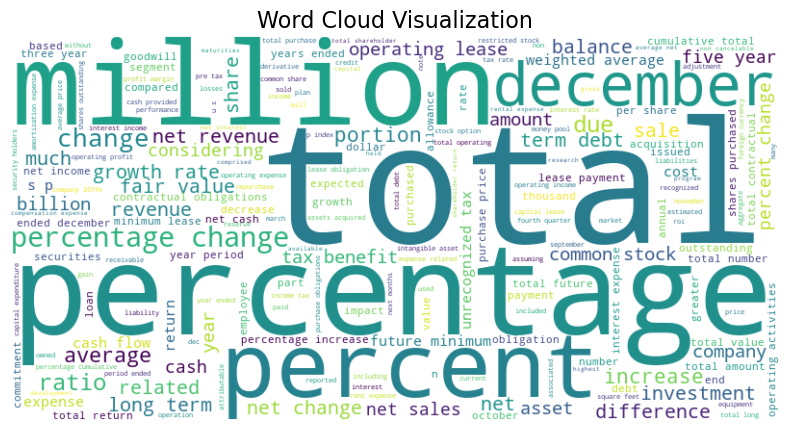

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gộp toàn bộ nội dung văn bản thành một chuỗi
text = " ".join(df["question"].dropna().astype(str).tolist())

# Tạo word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Vẽ ra
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud Visualization", fontsize=16)
plt.show()
